# Setup

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# SKlearn 
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,accuracy_score
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

## Multi-drug use

In [68]:
incidents = pd.read_csv('../data/Aggregated/incidents.csv', )
incidents['Multiple Drugs'] = 0
incidents.loc[incidents['All Drugs'].str.contains(' | ', regex = False), 'Multiple Drugs'] = 1
incidents[incidents['Multiple Drugs'] == 1].shape

(8050, 17)

In [69]:
cluster_Map = pd.read_csv('..\data\Aggregated\cluster_mapping.csv')

In [70]:
### fenytanl

incidents['Fentnyl'] = 0
incidents.loc[incidents['All Drugs'].str.contains('FENTANYL', regex = False), 'Fentnyl'] = 1
incidents[incidents['Fentnyl'] == 1].shape

(7255, 18)

In [71]:
incidents['Fentnyl'].value_counts()

0    13342
1     7255
Name: Fentnyl, dtype: int64

In [72]:
incidents.columns

Index(['Incident ID', 'Incident Date', 'Incident Time', 'Day',
       'Incident County Name', 'Incident State', 'Victim ID', 'Gender Desc',
       'Age Range', 'Race', 'Ethnicity Desc', 'Naloxone Administered',
       'Survive', 'Response Desc', 'All Drugs', 'Incident Date ym',
       'Multiple Drugs', 'Fentnyl'],
      dtype='object')

### Year, Month and Age Range

In [73]:
incidents["year"] = incidents['Incident Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').year)
incidents["month"] = incidents['Incident Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').month)

# Fix value typo
incidents["Age Range"] = incidents["Age Range"].apply(lambda x: "10 - 14" if x == "14-Oct" else x)

In [74]:
incidents.head(2)

,Incident ID,Incident Date,Incident Time,Day,Incident County Name,Incident State,Victim ID,Gender Desc,Age Range,Race,Ethnicity Desc,Naloxone Administered,Survive,Response Desc,All Drugs,Incident Date ym,Multiple Drugs,Fentnyl,year,month
0,1,1/4/2018,0:42:00,Thursday,Delaware,Pennsylvania,1,Male,50 - 59,White,Not Hispanic,1,0,NO RESPONSE TO NALOXONE,COCAINE/CRACK | HEROIN,2018,1,0,2018,1
1,26,1/26/2018,9:14:00,Friday,Chester,Pennsylvania,5,Male,25 - 29,White,Not Hispanic,0,0,None,HEROIN,2018,0,0,2018,1


In [75]:
incidents['Age Range'].value_counts()

30 - 39    7653
25 - 29    4082
40 - 49    3434
20 - 24    2030
50 - 59    1871
60 - 69     634
0 - 9       530
15 - 19     276
70 - 79      70
80 - *       10
10 - 14       7
Name: Age Range, dtype: int64

In [76]:
def agerange_weekend(df):
    for i, row in df.iterrows():
        if row['Day'] == 'Friday' or row['Day'] == 'Saturday' or row['Day'] == 'Sunday':
            df.loc[i,'Weekend_OD'] = 1
        else:
            df.loc[i,'Weekend_OD'] = 0
        
        if row['month'] == 1 or row['month'] == 12 or row['month'] == 2:
            df.loc[i,'Season'] = 'Winter'
        elif row['month'] == 3 or row['month'] == 4 or row['month'] == 5:
            df.loc[i,'Season'] = 'Spring'
        elif row['month'] == 6 or row['month'] == 7 or row['month'] == 8:
            df.loc[i,'Season'] = 'Summer'
        elif row['month'] == 9 or row['month'] == 10 or row['month'] == 11:
            df.loc[i,'Season'] = 'Fall' 
            
        if row['Age Range'] == '0 - 9' or row['Age Range'] == '10 - 14' or row['Age Range'] == '15 - 19' or row['Age Range'] == '20 - 24' or row['Age Range'] == '30 - 39':
            df.loc[i,'Over 40'] = 0
        else:    
        
            df.loc[i,'Over 40'] = 1
            
    return(df)            
                
            
            
            

In [77]:
incidents2 = agerange_weekend(incidents.copy())

In [78]:
incidents2.head(2)

,Incident ID,Incident Date,Incident Time,Day,Incident County Name,Incident State,Victim ID,Gender Desc,Age Range,Race,...,Response Desc,All Drugs,Incident Date ym,Multiple Drugs,Fentnyl,year,month,Weekend_OD,Season,Over 40
0,1,1/4/2018,0:42:00,Thursday,Delaware,Pennsylvania,1,Male,50 - 59,White,...,NO RESPONSE TO NALOXONE,COCAINE/CRACK | HEROIN,2018,1,0,2018,1,0.0,Winter,1.0
1,26,1/26/2018,9:14:00,Friday,Chester,Pennsylvania,5,Male,25 - 29,White,...,None,HEROIN,2018,0,0,2018,1,1.0,Winter,1.0


In [79]:
incidents2[['hour','min','second']] = incidents2['Incident Time'].str.split(':',expand=True)

In [80]:
def hoursplit(df):
    for i, row in df.iterrows():
        if row['hour'] in['1','2','3','4']:
            df.loc[i, 'time_period'] ='late_evening'
        elif row['hour'] in['5','6','7','8','9']: 
            df.loc[i, 'time_period'] ='early_morning'
        elif row['hour'] in['10','11','12','13','14']: 
            df.loc[i, 'time_period'] ='morning_afternoon'  
        elif row['hour'] in['15','16','17','18','19']: 
            df.loc[i, 'time_period'] ='afternoon_even'
        else:
            df.loc[i, 'time_period'] = 'evening'
    return(df)                
            

In [81]:
incidents2 = hoursplit(incidents2.copy())

In [82]:
incidents2['Over 40'] = incidents2['Over 40'].astype(int)
incidents2['Weekend_OD'] = incidents2['Weekend_OD'].astype(int)

In [83]:
cluster_Map.head()

,County,Cluster
0,Delaware,Zero
1,Chester,Zero
2,Beaver,One
3,Bucks,Zero
4,Philadelphia,Zero


In [84]:
incidents3 = pd.merge(incidents2,cluster_Map, how="inner",left_on = 'Incident County Name',right_on = 'County')

In [85]:
incidents3['Cluster'] = incidents3['Cluster'].astype(str)

In [86]:
def isphila(df):
    for i, row in df.iterrows():
        if row['Incident County Name'] == 'Philadelphia':
            df.loc[i,'Phila'] = 1
        else:
            df.loc[i,'Phila'] = 0
    return (df)        
            

In [87]:
incidents3 = isphila(incidents3.copy())

In [206]:


X = incidents3[['Season','Weekend_OD','Fentnyl','Race','Incident County Name','time_period']]
y = incidents3[['Naloxone Administered']]

In [207]:
y['Naloxone Administered'].value_counts()

1    14136
0     6433
Name: Naloxone Administered, dtype: int64

In [208]:
class_weight_m = {0:14151,1:6446}

## Pipeline Definition

In [209]:
##pipeline  
label_features =['Season','Race','Incident County Name','time_period']
label_transformer = OneHotEncoder(sparse = False, handle_unknown = 'ignore')



preprocessor = ColumnTransformer(
    transformers=[
        ('label', label_transformer, label_features)
        ])   


model =  Pipeline(steps=[('preprocessor', preprocessor),
                      ('randomforest', RandomForestClassifier(n_estimators=1000,
                                                              class_weight=class_weight_m))])

In [210]:
# Split data with stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=43)

In [211]:
model.fit(X_train,y_train)


C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('label', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=...rs=1000, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False))])

In [212]:
predictions_classweights = model.predict(X_test)
print("accuracy:",accuracy_score(y_test, predictions_classweights))

accuracy: 0.6161773284075442


In [213]:
from sklearn.model_selection import StratifiedKFold
import numpy
kf = StratifiedKFold(n_splits=5,random_state=0, shuffle=True)

 
acc_score = []
pred = []
y_test_all = []
predprob = []
 
for train_index , test_index in kf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
     
    model.fit(X_train,y_train)
    print(model.score(X_test, y_test))
    num = model.score(X_test, y_test)
    num = num.astype(float)
    acc_score.append(num)
    predictions_classweights = model.predict(X_test)
    proba = model.predict_proba(X_test)
    predprob.append(proba)                           
    
    #predict_class = np.argmax(test_predictions, axis=1)
    #predict_class = predict_class.tolist()
    
    pred.append(predictions_classweights)
    y_test_all.append(y_test)


C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.6177399756986635


C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.6254253767622752


C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.6178901312591152


C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.613177729151471


C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.6075857038657914


In [221]:
pred_master = np.hstack(([pred[0],pred[1],pred[2],pred[3],pred[4]]))
y_test_master = pd.concat(y_test_all)

In [222]:
pr0 = pd.DataFrame(predprob[0],columns=['zero','one'])
pr1 = pd.DataFrame(predprob[1],columns=['zero','one'])
pr2 = pd.DataFrame(predprob[2],columns=['zero','one'])
pr3 = pd.DataFrame(predprob[3],columns=['zero','one'])
pr4 = pd.DataFrame(predprob[4],columns=['zero','one'])

In [228]:
prdf1 = pd.concat([pr0,pr1,pr2,pr3,pr4])
prdf1 = prdf1[['one']]
prdf2 =prdf1.copy()

In [229]:
prdf2['one'] = np.select([prdf2['one']>=.54],  ### setting threshold
                        [1],
                        default=0)

In [230]:
confusion = confusion_matrix(y_test_master,prdf2)

In [231]:
print(confusion)

[[3670 2763]
 [5898 8238]]


In [232]:
target_names = ['Not Given Naloxone', 'Given Naloxone']
print(classification_report(y_test_master, prdf2, target_names=target_names))

                    precision    recall  f1-score   support

Not Given Naloxone       0.38      0.57      0.46      6433
    Given Naloxone       0.75      0.58      0.66     14136

         micro avg       0.58      0.58      0.58     20569
         macro avg       0.57      0.58      0.56     20569
      weighted avg       0.63      0.58      0.59     20569



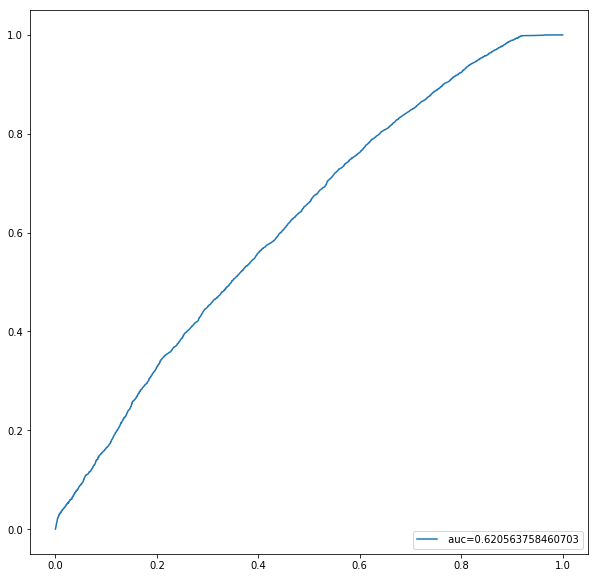

In [233]:
fpr, tpr, _ = metrics.roc_curve(y_test_master,prdf1)
auc = metrics.roc_auc_score(y_test_master,prdf1)
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,label=" auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [418]:

#### for gini importance
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

In [419]:
def row_to_dict(x,y=None):
    return X.apply(dict,axis=1)
    
ft = FunctionTransformer(row_to_dict, validate=False)
dv = DictVectorizer()
rf = RandomForestClassifier(n_estimators=1000)

model = make_pipeline(ft,dv,rf)
model.fit(X,y)
feature_importances = zip(dv.feature_names_,rf.feature_importances_)

 



C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [420]:
dv.feature_names_

['Fentnyl',
 'Incident County Name=Adams',
 'Incident County Name=Allegheny',
 'Incident County Name=Armstrong',
 'Incident County Name=Beaver',
 'Incident County Name=Bedford',
 'Incident County Name=Berks',
 'Incident County Name=Blair',
 'Incident County Name=Bradford',
 'Incident County Name=Bucks',
 'Incident County Name=Butler',
 'Incident County Name=Cambria',
 'Incident County Name=Carbon',
 'Incident County Name=Centre',
 'Incident County Name=Chester',
 'Incident County Name=Clarion',
 'Incident County Name=Clearfield',
 'Incident County Name=Clinton',
 'Incident County Name=Columbia',
 'Incident County Name=Crawford',
 'Incident County Name=Cumberland',
 'Incident County Name=Dauphin',
 'Incident County Name=Delaware',
 'Incident County Name=Elk',
 'Incident County Name=Erie',
 'Incident County Name=Fayette',
 'Incident County Name=Forest',
 'Incident County Name=Franklin',
 'Incident County Name=Fulton',
 'Incident County Name=Greene',
 'Incident County Name=Huntingdon',
 '

In [440]:
Fentnyl = rf.feature_importances_[0]
County = sum(rf.feature_importances_[1:67])
Race = sum(rf.feature_importances_[67:72])
Season = sum(rf.feature_importances_[72:76])
Weekend_OD = rf.feature_importances_[76]
Time_period = sum(rf.feature_importances_[77:82])

In [441]:
features=['Fentnyl','County','Race','Season','Weekend_OD','Time_Period']
importance=[Fentnyl,County,Race,Season,Weekend_OD,Time_period]

In [442]:
feats = {}
for feature, importance in zip(features,importance):
    feats[feature] = importance
    

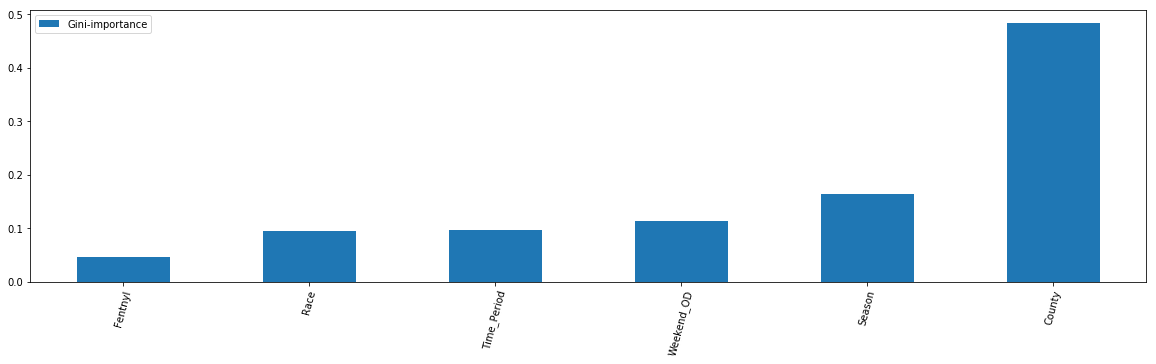

In [443]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=75, figsize =(20,5))